# Continuous Optimisation HW2

In [73]:
# Imports
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from tqdm import tqdm
from scipy.io import loadmat
import time


data = loadmat('data-toy.mat')
print(data.keys())
sigma = float(data['sigma'])

'''
K = data['K']
P = data['P']
X0 = data['X0']
d = data['d']
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = data['n']
sigma = data['sigma']
y = data['y']
'''

sigmasquared = sigma**2


dict_keys(['__header__', '__version__', '__globals__', 'K', 'P', 'X0', 'Xstar', 'd', 'delta_0', 'delta_bar', 'n', 'sigma', 'y'])


C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\2921735262.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma = float(data['sigma'])


# Question 1
Implement phi(x, P), bigphi(X, P), f(X, P, y).

In [74]:
# Question 1
#TODO Vectorise all the functions

def h(x: np.ndarray) -> float:
    """
    Gaussian filter

    :x: np.ndarray[(1, 2)]
    :returns: float
    """
    return np.e**(-np.inner(x, x)/sigmasquared)  # Always take sigma = 0.1


def phi(x,P):
    """
    Calculate contribution of each 'true' star to observed image
    
    :x: np.ndarray[(2, 1)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    # print(f"P is {P}")
    # print(f"x is {x}")
    # print(f"P-x is {P-x}")
    # print(h(P - x).reshape(-1, 1))
    # print((np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape(-1, 1))
    # return h(P - x).reshape(-1, 1)
    return (np.e**((-1/sigmasquared)*np.sum((P.T-x.T)**2,axis=1))).reshape(-1, 1)


def bigphi(X, P):
    """
    Calculate image observed, based on K-star positions X
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 1)]
    """
    global K, n
    X = X.flatten()
    #non-vectorised code just in case we need it
    bigphi = np.zeros((n**2, 1))
    for i in range(K):
        bigphi += phi(X[2*i:2*i+2], P)
    #return phi(X, P)
    return bigphi


def  f(X, P, y):
    """
    Calculate squared error of estimate bigphi(X)
    
    :X: np.ndarray[(2, K)]
    :P: np.ndarray[(2, n**2)]
    :y: np.ndarray[(n**2, 1)]
    :returns: float
    """
    global n
    return (1/(2*n**2)) * np.linalg.norm(bigphi(X, P)-y)**2


# Question 2

We see that $f$ is not convex. There are clear local maxima which cannot occur if $f$ were convex.

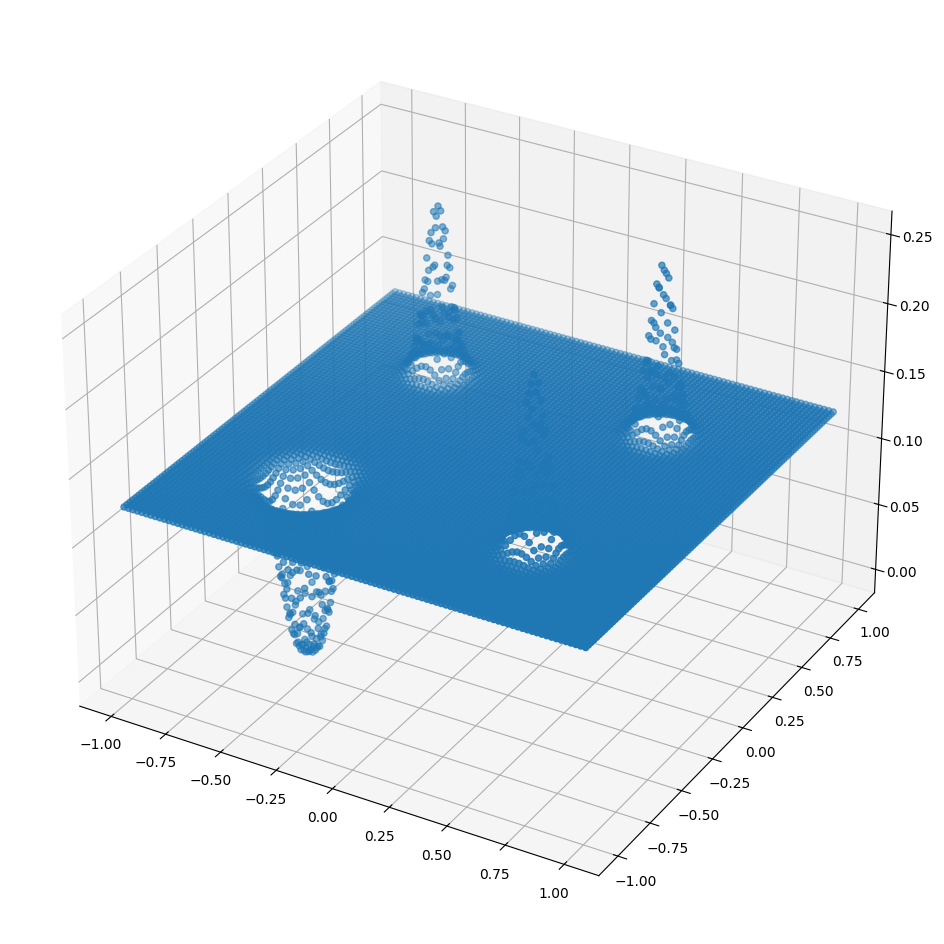

In [75]:
K = 1
n = 2
true_positions = np.array([[0], [0]])
positions = np.array([[0.5, 0.5], [-0.5, 0.5], [-0.5, -0.5], [0.5, -0.5]]).T
y = np.array([[0], [0], [1], [0]])
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

x_vals = np.linspace(-1, 1, 100)
y_vals = np.linspace(-1, 1, 100)
x_vals, y_vals = np.meshgrid(x_vals, y_vals)
grid = np.array([x_vals, y_vals]).reshape((2, 100**2))
z_vals = np.zeros((1, 10000))
for i in range(10000):
    z_vals[0, i] = f(grid[:, i].reshape((2, 1)), positions, y)
z_vals = z_vals.reshape((100, 100))
ax.scatter(x_vals, y_vals, z_vals)
plt.show()
plt.show()

# Question 6.1

In [76]:
def d_phi_i_0(x,p_i):
    """
    Computes value of cell i_0 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[0]-x[0])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))

def d_phi_i_1(x,p_i):
    """
    Computes value of cell i_1 of jacobian of phi
    
    :x: np.ndarray[(2, 1)]
    :p_i: np.ndarray[(2, 1)]
    :returns: float
    """
    return (2/sigmasquared)*(p_i[1]-x[1])*np.e**((-1/sigmasquared)*np.inner(p_i-x,p_i-x))
    
def d_phi(x, P):
    """
    Computes the jacobian of small phi

    :x: np.ndarray[(1, 2)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2)]
    """
    # Subtract x from each column of P
    diff = P.T - x
    # Compute the squared differences
    squared_diff = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    exp_term = np.exp((-1 / sigmasquared) * squared_diff)
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_phi_0 = (2 / sigmasquared) * diff[:, 0] * exp_term
    d_phi_1 = (2 / sigmasquared) * diff[:, 1] * exp_term
    # Stack the results to form the final array
    d_phi = np.stack((d_phi_0, d_phi_1), axis=1)
    return d_phi

def d_big_phi(X,P):
    """
    Computes the jacobian of big phi

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_big_phi = np.zeros((n**2,2*K))
    for i in range(K):
        d_big_phi[0:n**2,2*i:2*i+2] = d_phi(X[2*i:2*i+2].T,P)
    return d_big_phi

def d_f(X,P):
    """
    Computes the jacobian of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(1, 2K)]
    """
    return (1/n**2)*(bigphi(X,P)-y).T@d_big_phi(X,P)

#compute gradient of f
def grad_f(X,P):
    """
    Computes the gradient of f

    :X: np.ndarray[(1, 2K)]
    :P: np.ndarray[(2, n**2)]
    :returns: np.ndarray[(2K, 1)]
    """
    return d_f(X,P).T

# Question 6.2

C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\2354262383.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K = int(data['K'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\2354262383.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d = int(data['d'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\2354262383.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(data['n'])
C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\2354262383.py:9: Deprecatio

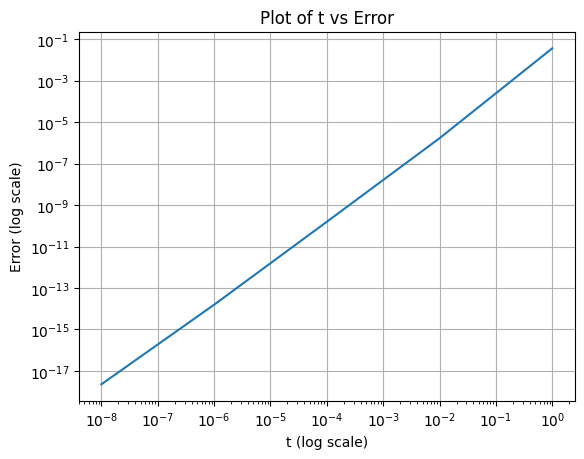

In [77]:
#checking gradient is correct numerically
K = int(data['K'])
P = data['P']
X0 = data['X0']
d = int(data['d'])
delta_0 = data['delta_0']
delta_bar = data['delta_bar']
n = int(data['n'])
sigma = float(data['sigma'])
y = data['y'].flatten(order='F').reshape(n**2,1)

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + O(t^2)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = v / np.linalg.norm(v)

## Check the gradient 
def checkgradient(f,grad_f, theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=5)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    #compute the error at each t
    for i in tqdm(range(5)):
        error[i] = np.abs( f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad) )
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkgradient(f,grad_f,theta,v)

# Question 7

## Computing the Hessian 

First we re-derive the gradient of f:

$$ f(x) = \frac{1}{2n^2}||\Phi(x) - y ||^2$$

$$ Df(x)[v] = \frac{1}{n^2}< \Phi(x) - y,D \Phi(x)[v] > = \frac{1}{n^2}<(D\Phi(x))^*[\Phi(x) - y],v> $$

$$ \nabla f(x) = \frac{(D\Phi(x))^*[\Phi(x) - y]}{n^2} $$

Then, using the above calculations, we can calculate the hessian:

$$ \frac{1}{n^2}[D((D\Phi(x))^*[\Phi(x) - y])[v]] = \frac{1}{n^2}[D((D\Phi(x))^*[v])[\Phi(x) - y] + (D\Phi(x))^*[D\Phi(x)[v]]]$$


$$ \nabla^2 f(x)[v] = \frac{1}{n^2}[(D(D\Phi(x))^*[v])[\Phi(x)-y]+D\Phi(x)^*[D\Phi(x)[v]]] $$

The implicit reason why we are calculating the hessian with respect to a direction v is because it is computationally much cheaper than to calculate the full hessian which means calculating all 2nd order partial derivatives of f.



In [78]:
def d_g(x,P,v):
    #subtract x from each column of P
    diff = P.T-x
    # Compute the squared differences
    squared_diff = diff**2
    norm_squared = np.sum(diff**2, axis=1)
    # Compute the exponential term for all elements at once
    a_1 = np.exp((-1 / sigmasquared) * norm_squared)*(2 / sigmasquared)**2
    # Compute the values for d_phi_i_0 and d_phi_i_1 using vectorized operations
    d_g_1_0 = a_1 *(v[0]*(squared_diff[:,0]-(sigmasquared/2))+v[1]*diff[:,0]*diff[:,1])
    d_g_1_1 = a_1 *(v[1]*(squared_diff[:,1]-(sigmasquared/2))+v[0]*diff[:,0]*diff[:,1])
    # Stack the results to form the final array
    d_g = np.stack((d_g_1_0, d_g_1_1), axis=1)
    return d_g
    


def d_d_phi(X, P, V):
    """
    Compute the directional derivative of the Jacobian of phi at x in the direction v.

    :param X: np.ndarray[(1, 2K)] "position of a stat"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param V: np.ndarray[(1, 2K)] "vector direction of change in star position"
    :returns: np.ndarray[(n**2, 2K)]
    """
    d_d_phi = np.zeros((n**2,2*K))
    for i in range(K):
            d_d_phi[0:n**2,2*i:2*i+2] = d_g(X[2*i:2*i+2].T,P,V[2*i:2*i+2])
    return d_d_phi
    


def hessian_f(X,V):
    """
    Compute the Hessian of f at X in the direction v.
    
    :param X: np.ndarray[(1, 2K)] "position of K stars"
    :param P: np.ndarray[(2, n**2)] "pixel positions"
    :param y: np.ndarray[(n**2, 1)] "actual image detected, y = \Phi(X_true)" remember we want to find X_true
    :param v: np.ndarray[(2, K)] "direction at which hessian is taken" 
    :returns: np.ndarray[(2*K, 1)]
    """
    # Compute intermediate terms
    phi_X = bigphi(X, P) - y  # (n**2, 1)
    d_big_phi_X = d_big_phi(X, P)  # (n**2, 2*K)
    d_big_phi_X_v = d_big_phi_X @ V  # directional derivative of big_phi in direction v

    # Compute each term in the Hessian formula

    term1 = d_d_phi(X, P, V).T @ phi_X 
    term2 = d_big_phi_X.T @ d_big_phi_X_v 

    hessian = (1 / n**2) * (term1 + term2)
    return hessian



<>:35: SyntaxWarning: invalid escape sequence '\P'
<>:35: SyntaxWarning: invalid escape sequence '\P'
C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\3794770577.py:35: SyntaxWarning: invalid escape sequence '\P'
  """


# Question 8


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\4020825566.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
100%|██████████| 100/100 [00:00<00:00, 2351.55it/s]


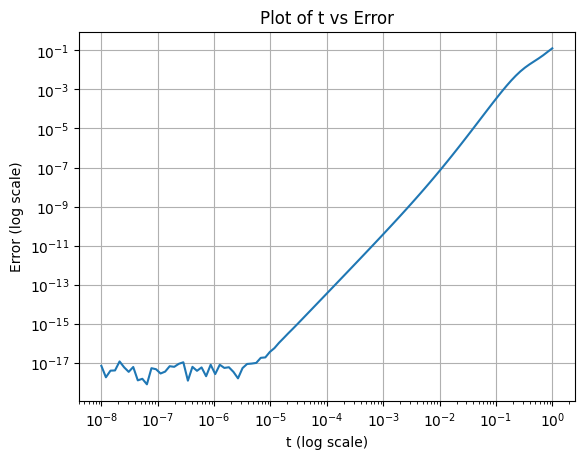

In [79]:

X_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)  # Random X
U_random = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)  # Random direction U
U_random /= np.linalg.norm(U_random)  # Normalize U

#check that the gradient is correct using
# f(x+tv)= f(x) + t<v,grad_f(x)> + t^2/2*v.T@hess_f(x)[v] + O(t^3)

# Generate a random point and a random direction
theta = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = np.random.uniform(-0.5, 0.5, (d, K)).flatten(order='F').reshape(d*K,1)
v = v / np.linalg.norm(v)

## Check the hessian 
def checkhessian(f,grad_f,hessian_f,theta,v):
    #logspace of t values
    t=np.logspace(-8, 0, num=100)
    #intialise error to 0
    error = np.zeros_like(t)
    #pre-calculae f_lambda and f_lambda_grad to use in for loop
    f_lambda = f(theta,P,y)
    f_lambda_grad = grad_f(theta,P)
    f_lambda_hess_v = hessian_f(theta,v)
    #compute the error at each t
    for i in tqdm(range(100)):
        error[i] = np.abs(f(theta+(t[i]*v),P,y)-f_lambda-(t[i]*v.T@f_lambda_grad)- ((t[i]**2)/2)*v.T@f_lambda_hess_v)
        
    #plot the graph of error vs t
    plt.loglog(t,error)
    plt.xlabel('t (log scale)')
    plt.ylabel('Error (log scale)')
    plt.title('Plot of t vs Error')
    plt.grid()
    plt.show
checkhessian(f,grad_f,hessian_f,theta,v)

# Question 9

In [80]:
def tCG(b: np.array, radius: float) -> tuple:
    """
    Solve the trust-region subproblem using tCG

    :param b: np.array[(2, K)]
    :param radius: float
    :returns: tuple(np.array(2*K, 1), np.array(2*K, 1), bool)
    """
    global K
    b = b.reshape(-1, 1)
    v0, r0, p0 = np.zeros((2 * K, 1)), b, b  # Here, when there is a "0" after the variable, it means it's the "iterated" variable ie it changes on every loop
    while True:
        Hp = hessian_f(b, p0)
        inner = np.inner(p0.flatten(), Hp.flatten())
        alpha = np.inner(r0.flatten(), r0.flatten())/inner
        v_plus = v0 + alpha * p0
        if inner <= 0 or np.linalg.norm(v_plus) >= radius:
            inner_pv = np.inner(v0.flatten(), p0.flatten())
            norm2_p = np.inner(p0.flatten(), p0.flatten())
            t = (-np.sqrt(inner_pv) + np.sqrt(inner_pv - (inner_pv - radius**2) * norm2_p))/norm2_p
            v0 += t * p0
            return (v0, b - r0 + t*Hp, True)  # since we solved ||v0|| = Delta, the flag is true
        else:
            v0 = v_plus
        r_old = r0
        r0 -= alpha * Hp
        if np.linalg.norm(r0) <= np.linalg.norm(b) * min(np.linalg.norm(r0), 0.1):
            return (v0, b - r0, False)  # flag is false
        beta0 = np.inner(r0.flatten(), r0.flatten())/np.inner(r_old.flatten(), r_old.flatten())
        p0 = (r0.flatten() + (beta0 * p0).flatten()).reshape(6, 1)


print(tCG(grad_f(X0.flatten(), P), 0.25))


(array([[ 0.16255271],
       [-0.06170145],
       [-0.19685084],
       [ 0.04265528],
       [-0.00519682],
       [ 0.00149255]]), array([[-0.26237669],
       [-0.05430246],
       [ 0.29822675],
       [-0.10310163],
       [-0.02293527],
       [ 0.14618616]]), True)


# Question 10

In [ ]:
def TRsolver(x0: np.array, Delta0: float, DeltaBar: float, rhoPrime: float=0.1, tol=0.001, time_limit = 10) -> np.array:
    """TrustRegion solver
    
    :param x0: np.ndarray[(2, K))]
    :param Delta0: float
    :param DeltaBar: float
    :param rhoPrime: float
    :returns: np.array[(2, K)]
    """
    global K, P, y
    start_time = time.time()
    gradient = 100
    iterates = []
    gradient_list = []
    while gradient > tol:  # replace with while loop, with a stopping criterion
        iterates.append(x0)
        grad_x0 = grad_f(x0.flatten(), P)
        TRsub = tCG(grad_x0, Delta0)
        x0_plus = x0 + TRsub[0].reshape(2, K)
        rho = (f(x0_plus, P, y) - f(x0, P, y))/(0.5 * np.inner(TRsub[0].flatten(), TRsub[1].flatten()) + np.inner(grad_x0.flatten(), TRsub[0].flatten()))
        if rho > rhoPrime:
            x0 = x0_plus

        if rho < 0.25:
            Delta0 = 0.25 * Delta0
        elif rho > 0.75 and TRsub[2]:
            Delta0 = min(2*Delta0, DeltaBar)
        else:
            pass
        gradient = np.linalg.norm(grad_f(x0.flatten(), P))
        print(np.linalg.norm(gradient))
        gradient_list.append(np.linalg.norm(gradient))
        if time.time() - start_time > time_limit:
            print(f"Reached time limit of {time_limit}s!")
            break
    return (x0, iterates, gradient_list)

print(X0.shape)
print(TRsolver(X0, delta_0, delta_bar))
        

(2, 3)
0.1300752480416098
0.15179301886712704
0.21133712997441545
0.09860276638618982
0.09860276638618982
0.03550475235586962
0.09832264573734106
0.09832264573734106
0.033071979973507123
0.033071979973507123
0.016038554851504454
0.016038554851504454
0.0076746495342400215
0.009399991047434364
0.024579518632835494
0.04412124337940313
0.04412124337940313
0.009964232421247811
0.05782609692346618
0.05782609692346618
0.023958515704009316
0.044782779051595785
0.044782779051595785
0.010572794354290812
0.057656573269108696
0.057656573269108696
0.02377476933618826
0.04497834506454983
0.04497834506454983
0.010755154901449376
0.057588174729595966
0.057588174729595966
0.02370326905781667
0.045050369125896446
0.045050369125896446
0.010824973495274353
0.05755241591703103
0.05755241591703103
0.023668008051544114
0.04508240648642385
0.04508240648642385
0.01085820675730938
0.05752845427571874
0.05752845427571874
0.023645524730258678
0.04510085054782275
0.04510085054782275
0.010878722901296921
0.05750934

# Question 11
Run the trust-region algorithm with truncated-CG on data-toy.mat starting from the initial point x0 provided in the dataset.

0.1300752480416098
0.15179301886712704
0.21133712997441545
0.09860276638618982
0.09860276638618982
0.03550475235586962
0.09832264573734106
0.09832264573734106
0.033071979973507123
0.033071979973507123
0.016038554851504454
0.016038554851504454
0.0076746495342400215
0.009399991047434364
0.024579518632835494
0.04412124337940313
0.04412124337940313
0.009964232421247811
0.05782609692346618
0.05782609692346618
0.023958515704009316
0.044782779051595785
0.044782779051595785
0.010572794354290812
0.057656573269108696
0.057656573269108696
0.02377476933618826
0.04497834506454983
0.04497834506454983
0.010755154901449376
0.057588174729595966
0.057588174729595966
0.02370326905781667
0.045050369125896446
0.045050369125896446
0.010824973495274353
0.05755241591703103
0.05755241591703103
0.023668008051544114
0.04508240648642385
0.04508240648642385
0.01085820675730938
0.05752845427571874
0.05752845427571874
0.023645524730258678
0.04510085054782275
0.04510085054782275
0.010878722901296921
0.057509349658999

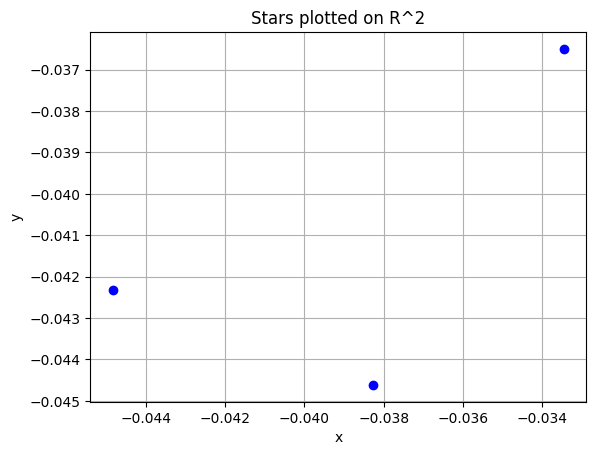

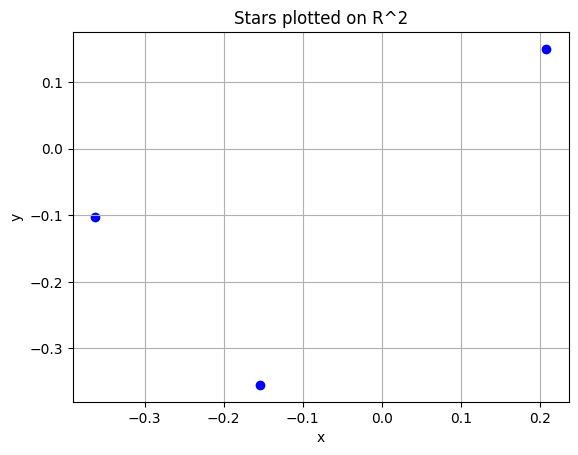

In [82]:
def plotting_stars(Random_intial_point:np.array = X0, Delta0: float = delta_0, DeltaBar: float = delta_bar,  rhoPrime: float=0.1, tol=0.001, time_limit = 30):
    """
    usual input: random initial starting point for Trsolver, usually taken to be given by the dataset

    :param Delta0: float
    :param DeltaBar: float
    :param rhoPrime: float
    :param tol: float
    param time_limit: float
    """
    
    # x0 = X0.flatten(order='F').reshape(d*K,1) #x0 
    points = TRsolver(X0, Delta0, DeltaBar, rhoPrime, tol, time_limit)[0]
    points = points.reshape(2, K) #reshapping again to for plotting now 

    # Separate x and y coordinates for plotting
    x = points[0,:]
    y = points[1,:]

    # Create the scatter plot
    plt.scatter(x, y, color='blue', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Stars plotted on R^2')
    plt.grid(True)
    plt.show()

    point2 = data['Xstar']
    points = point2.reshape(2, K) #reshapping again to for plotting now 

    # Separate x and y coordinates for plotting
    x = points[0,:]
    y = points[1,:]

    # Create the scatter plot
    plt.scatter(x, y, color='blue', marker='o')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Stars plotted on R^2')
    plt.grid(True)
    plt.show()



plotting_stars()


#code tested for both data sets. works.

# Question 12
Run the trust-region method several times on data.mat with different random initial points.

Hypothesis before having run the code: Since the function is non-convex, the trust-region algorithm might converge to different local minima depending on the initial point, leading to varying objective values across runs. If the stars in the dataset are well-separated (like in toy data sets), the results might be more consistent as the algorithm converges near true positions. However, for data.mat, where stars are closer and configurations more complex, we're more likely to see variability in the objective values due to multiple plausible configurations.

0.1300752480416098
0.15179301886712704
0.21133712997441545
0.09860276638618982
0.09860276638618982
0.03550475235586962
0.09832264573734106
0.09832264573734106
0.033071979973507123
0.033071979973507123
0.016038554851504454
0.016038554851504454
0.0076746495342400215
0.009399991047434364
0.024579518632835494
0.04412124337940313
0.04412124337940313
0.009964232421247811
0.05782609692346618
0.05782609692346618
0.023958515704009316
0.044782779051595785
0.044782779051595785
0.010572794354290812
0.057656573269108696
0.057656573269108696
0.02377476933618826
0.04497834506454983
0.04497834506454983
0.010755154901449376
0.057588174729595966
0.057588174729595966
0.02370326905781667
0.045050369125896446
0.045050369125896446
0.010824973495274353
0.05755241591703103
0.05755241591703103
0.023668008051544114
0.04508240648642385
0.04508240648642385
0.01085820675730938
0.05752845427571874
0.05752845427571874
0.023645524730258678
0.04510085054782275
0.04510085054782275
0.010878722901296921
0.057509349658999

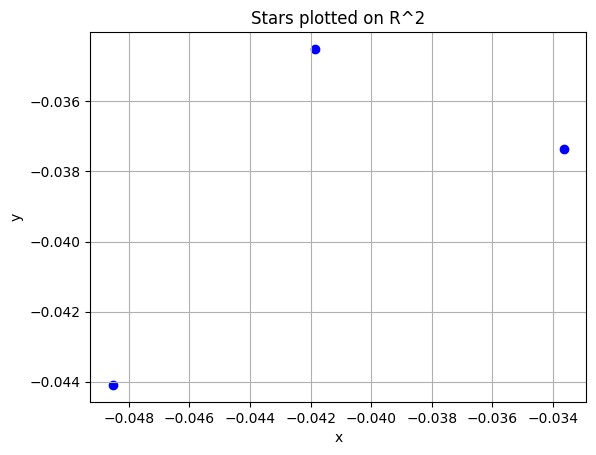

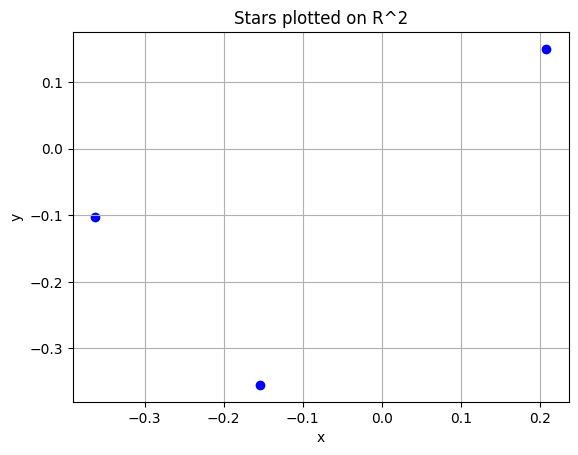

In [87]:
# random intial points np.ndarray[(2K,1)]

starting_point_ex_1 = np.zeros((2,K))

starting_point_ex_2 = np.ones((2,K))

# continue testing, with random points, etc 

plotting_stars(starting_point_ex_1)
#plotting_stars(starting_point_ex_2)

# Question 13
Run the trust-region algorithm on data.mat starting from the point x0 provided in thedataset.

Plot the norm of the gradient ∥∇f(xk)∥ as a function of k (gradient norm always on a log-scale). Do the same thing as a function of computation time.

In [90]:
# plotting function for gradient norm vs iteration number
def plot_gradient_norm(gradient_norms:np.ndarray):
    plt.plot(gradient_norms, marker='o', linestyle='-', color='b')
    plt.title("Gradient Norm vs. Iteration Number") # need to maybe change this to a different title ###################
    plt.xlabel("Iteration Number")
    plt.ylabel("Gradient Norm (log scale)")
    plt.yscale('log')
    plt.grid()
    plt.show()

#x0
x0 = X0  #x0
#x0, iterates,gradient_norms1,times = TRsolver(x0, delta_0, delta_bar)

#x_random
x_random = np.random.uniform(-0.5, 0.5, (d, K))  # Random X
x0, iterates,gradient_norms2,times = TRsolver(x_random, delta_0, delta_bar)

#x_random2
x_random2 = np.random.uniform(-0.5, 0.5, (d, K))  # Random X
#x0, iterates,gradient_norms3,times = TRsolver(x_random2, delta_0, delta_bar)

#plot_gradient_norm(gradient_norms1);
plot_gradient_norm(gradient_norms2);
#plot_gradient_norm(gradient_norms3);

C:\Users\gzein\AppData\Local\Temp\ipykernel_7972\3225348065.py:20: RuntimeWarning: invalid value encountered in sqrt
  t = (-np.sqrt(inner_pv) + np.sqrt(inner_pv - (inner_pv - radius**2) * norm2_p))/norm2_p


0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327
0.14765353026108327


ValueError: not enough values to unpack (expected 4, got 2)

In [85]:
# # Question 13

# # backtracking line search to find alpha value
# def alpha_finder(f: callable, del_f: callable, x: np.array, alpha: float, c=10**(-4), step=0.5) -> float:
#     #calculate f value, gradient and norm squared outside of while loop to save computatiion
#     f_x = f(x,P,y)
#     del_fx = del_f(x,P)
#     del_fx_norm_squared =np.linalg.norm(del_fx)**2
#     #alpha finder (backtracking line search)
#     while (f_x - f(x-alpha*del_fx,P,y)) < c*alpha*del_fx_norm_squared:
#         alpha = step * alpha
#     return alpha

# #implementation of gd using backtracking line search with dynamic alpha
# def armijo_line_search_more(f: callable, del_f: callable, x0: List[float], alpha=0.5,c=10**(-4), tol=10**(-4), max_time = 30, e_threshold = 10**(-3)) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:

#     # intitialising and assigning values
#     initial_time = time.time()
#     time_array = [0] 
#     x_approximations = [x0] 
#     #initialise gradient and gradient norm
#     del_fx1= del_f(x0,P)
#     del_fx1norm = np.linalg.norm(del_fx1)
#     #initialise array gradient norms and k
#     gradient_norm_values = [del_fx1norm]
#     k=0

#     # body of function
#     while (del_fx1norm > tol):
#         #calculate which iteration we're on
#         k = k+1
#         #calculate alpha using armijo line search
#         alpha = alpha_finder(f, del_f, x0, alpha,c)
#         #calculate new xk value
#         x0 = x0 - alpha * del_fx1
#         x_approximations.append(x0)
#         #calculate gradient and gradient norm
#         del_fx1= del_f(x0,P)
#         del_fx1norm = np.linalg.norm(del_fx1)
#         #updating time and gradient_norm array
#         gradient_norm_values.append(del_fx1norm)
#         time_array.append(time.time()-initial_time)
        
    
#         # testing to see if algorithm exceeds runtime
#         if (time_array[-1] - time_array[0]) > max_time:
#             print(f"Gradient descent algorithm exceeded {max_time/60} minutes run time. Algorithm stopped")
#             break

#         # testing to see if the incremental steps from the gradient are too small (used to test if we're already close to the solution)
#         if (np.abs(gradient_norm_values[0] - gradient_norm_values[-1])) < e_threshold:
#             print(f"Ratio of Gradient norms (|G[f]xk|,|G[f]x0|) was less than {e_threshold} for {k}th iteration, algorithm stopped")
#             break

#     return np.array(x_approximations),np.array(gradient_norm_values),np.array(time_array)


# #x0
# x0 = X0.flatten(order='F').reshape(d*K,1) #x0 
# #running armijo line search GD with rho = 0.8, c = 10^-4 for 3 mins and store value of greadient norms and runtime
# x_min2, grad_norms4, runtime2 = armijo_line_search_more(f, grad_f,x0,0.8, 10**(-4))
# plot_gradient_norm(grad_norms4);

In [86]:
# #chatgpt testing stuff
# def truncated_conjugate_gradient(x, gradient_func, hessian_func, radius, max_iters=10):
#     """
#     Truncated Conjugate Gradient to solve the trust region subproblem.
#     """
#     g = gradient_func(x,P)
  
#     d = -g  # Initial direction (negative gradient)
#     s = np.zeros_like(x)  # Initial step is zero
#     residual = g.copy()
    
#     for _ in range(max_iters):
#         hess_d = hessian_func(x,d)
#         alpha = (residual.T @ residual) / (d.T @ hess_d)
        
#         # Compute candidate step
#         s_new = s + alpha * d
#         # Check if s_new is outside the trust region; if so, truncate
#         if np.linalg.norm(s_new) >= radius:
#             tau = (-s.T @ d + np.sqrt((s.T @ d)**2 + d.T @ d * (radius**2 - s.T @ s))) / (d.T @ d)
#             s = s + tau * d
#             break
        
#         # Update step
#         s = s_new
#         residual_new = residual - alpha * hess_d
        
#         # Check for convergence
#         if np.linalg.norm(residual_new) < 1e-5:
#             break
        
#         # Update direction with conjugate gradient adjustment
#         beta = (residual_new.T @ residual_new) / (residual.T @ residual)
#         d = -residual_new + beta * d
#         residual = residual_new
    
#     return s

# def trust_region_method(x0, gradient_func, hessian_func, max_radius, delta_0, rho_prime=0.1, max_iters=50):
#     """
#     Trust Region Method using a quadratic model and truncated conjugate gradient.
#     """
#     x = x0.copy()
#     delta = delta_0
#     gradient_norms = []

#     for k in range(max_iters):
#         grad = gradient_func(x,P)
#         grad_norm = np.linalg.norm(grad)
#         gradient_norms.append(grad_norm)  # Store the gradient norm

#         if grad_norm < 1e-5:
#             print("Gradient close to zero, stopping optimization.")
#             break
        
#         # Inner truncated CG with delta as the maximum allowable step
#         u_k = truncated_conjugate_gradient(x, gradient_func, hessian_func, delta)
#         x_plus = x + u_k
        
#         # Calculate the actual and model reductions
#         actual_reduction = f(x,P,y) - f(x_plus,P,y)
#         s = u_k
#         hess_s = hessian_func(x,s)
#         model_reduction = grad.T @ s + 0.5 * s.T @ hess_s
        
#         # Compute the ratio of actual to model improvement
#         rho_k = actual_reduction / (-model_reduction)  # Avoid division by zero

#         # Accept or reject the tentative next iterate
#         if rho_k > rho_prime:
#             x = x_plus  # Accept the step
#         else:
#             x = x  # Reject the step (x remains the same)

#         # Update the trust-region radius based on rho_k
#         if rho_k < 0.25:
#             delta = 0.25 * delta
#         elif rho_k > 0.75 and np.abs(np.linalg.norm(u_k)- delta)<10**(-8):
#             delta = min(2 * delta, max_radius)
#         else:
#             delta = delta
        
#         print(f"Iteration {k+1}, delta = {delta}, norm u_k = {np.linalg.norm(u_k)},rho_k = {rho_k}, gradient norm = {grad_norm}")
    
#     return x, gradient_norms

# # Initial point
# x_random = np.random.uniform(-0.001, 0.001, (d, K)).flatten(order='F').reshape(d*K,1)  # Random X
# solution,grad_norms5 = trust_region_method(x_random, grad_f, hessian_f,delta_bar, delta_0)
# plot_gradient_norm(grad_norms5);